# Conditional Gaussian Likelihood
Here we go through a simple example of recovering a posterior with SBI. For this, we will use an analytic model, for which we can then compare the result of a fitted and analytic likelihood (and posterior).

## Model
The simple model has two parameteres, $\mu_0$ and $\sigma_0$. Prior distributions are defined as:
$$P(\mu_0) = \frac{1}{2\pi} \exp \left(-\frac{1}{2} \mu_0^2\right)$$
$$P(\log_{10} \sigma_0) = \begin{cases} 1 & \text{for} -1/2 < \log_{10} \sigma_0 < 1/2 \\ 0 & \text{otherwise}\end{cases}$$

We'll work in a 5D data space, where the analytic likelihood is given by:
$$P(\boldsymbol{d} | \mu_0, \sigma_0) = \frac{1}{(2\pi)^{5/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (\boldsymbol{d} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{d} - \boldsymbol{\mu})\right) \, ,$$
where $$\boldsymbol{\mu} = (1^2, 2^2, 3^2, 4^2, 5^2) \cdot \mu_0 \, ,$$
$$\Sigma = 
\begin{pmatrix}
1^2 & 0 & 0 & 0 & 0\\
0 & 2^2 & 0 & 0 & 0\\
0 & 0 & 3^2 & 0 & 0\\
0 & 0 & 0 & 4^2 & 0\\
0 & 0 & 0 & 0 & 5^2
\end{pmatrix} \cdot \sigma^2_0 \, .$$

## Fitting the likelihood
To fit the likelihood we create 100 000 data samples of the likelihood function, for $\mu_0$ and $\sigma_0$ pulled from the prior. In this way, the training set follows the prior distribution. This is not strictly necessary. Because we fit the likelihood, final posterior recovery will be insensitive on how were the training samples constructed. The benefit of using the real prior however, is to allow the network to learn important part of the parameter space.

## Mock measurement
With this at hand, we sample 10 points from the analytic likelihood as our mock measurement, for fixed $\mu_0 = 1$, $\sigma_0 = 1$ and try to recover posterior using the fitted likelihood. The final result is then compared with the posterior recovered from the analytic likelihood.



In [1]:
# setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

from functools import partial
import logging
import corner
import ultranest
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from py21cmlikelihoods import ConditionalGaussian

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ultranest_logger = logging.getLogger("ultranest")
ultranest_logger.addHandler(logging.NullHandler())
ultranest_logger.setLevel(logging.INFO)

2023-05-05 11:03:26.243181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# constructing the training set
mu_0 = np.random.normal(0.0, 1.0, size = 100000)
sigma_0 = 10 ** np.random.uniform(-0.5, 0.5, size = 100000)
params = np.stack([mu_0, sigma_0], axis = -1)
train_params = tf.data.Dataset.from_tensor_slices(params)

data = np.array([np.random.multivariate_normal(np.arange(1, 6)**2 * m, np.diag(np.arange(1, 6)**2 * s**2)) for m, s in params])
train_data = tf.data.Dataset.from_tensor_slices(data)

training_set = tf.data.Dataset.zip((train_params, train_data)).shuffle(100000).batch(100)

2023-05-05 11:03:35.215102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# constructing and training the likelihood
NDE = ConditionalGaussian(
    n_parameters = 2, 
    n_data = 5, 
    diagonal_covariance = True,
    n_hidden = [50] * 10,
    optimizer = tf.optimizers.Adam(1e-3), 
    kernel_initializer = partial(tf.keras.initializers.RandomNormal, mean=0, stddev=1e-5, seed=None),
    final_bias_initializer = "ones",
)
NDE.train(
    epochs = 100,
    dataset = training_set,
    pretrain = True,
    pretrain_epochs = 10,
    pretrain_optimizer = tf.optimizers.Adam(1e-3), 
    save = False,
    save_history = False,
    verbose = 1,
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Epoch 1/10
1000/1000 [==============================] - 5s 3ms/step - loss: 146.4701
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 59.9786
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 60.1431
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 59.9342
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 60.0699
Epoch 6/10
1000/1000 [==============================] - 4s 3ms/step - loss: 60.0257
Epoch 7/10
1000/1000 [==============================] - 4s 3ms/step - loss: 59.9729
Epoch 8/10
1000/1000 [==============================] - 6s 5ms/step - loss: 59.9869
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 59.9000
Epoch 10/10
1000/1000 [==============================] - 4s 4ms/step - loss: 59.9926
Epoch 1/100
1000/1000 [===========

[ 1.8925481  7.730644  17.386656  31.151653  48.09856  ] [0.95540524 1.9015791  3.1419442  4.3114586  4.88893   ]
[ 2.00136235  7.98957469 17.99672    32.01200836 50.00170789] [0.99354379 1.99924718 2.99212088 3.989089   5.00261023]


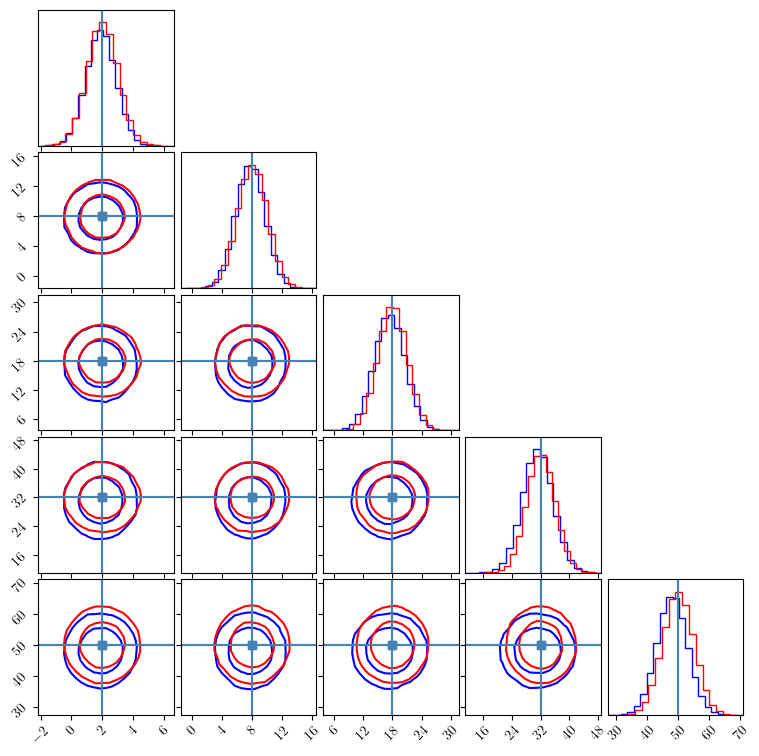

In [4]:
# testing the likelihood shape for mu_0 = 2, sigma_0 = 1
NDE_sample = NDE.sample(100000, conditional = tf.constant([2.0, 1.0])).numpy()
analytic_sample = np.random.multivariate_normal(np.arange(1, 6)**2 * 2, np.diag(np.arange(1, 6)**2), 100000)

fig = plt.figure(figsize = (8, 8))
corner.corner(
    NDE_sample, 
    fig = fig, 
    color = "blue", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
corner.corner(
    analytic_sample, 
    fig = fig, 
    color = "red", 
    truths = np.arange(1, 6)**2 * 2, 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
)
print(NDE_sample.mean(axis = 0), NDE_sample.std(axis = 0))
print(analytic_sample.mean(axis = 0), analytic_sample.std(axis = 0))

# Recovering posterior
To recover posterior we use fitted NDE likelihood and analytic likelihood, together with prior specified at the beginning. For sampling, we use `ultranest` nested sampler.

As previously mentioned, for the mock measurement we use 10 i.i.d. samples for $\mu_0 = 1$ and $\sigma_0 = 1$. The hope is that final posterior shifts towards those values.

In [5]:
mock_measurement = np.random.multivariate_normal(np.arange(1, 6)**2, np.diag(np.arange(1, 6)**2), 10)

In [6]:
def log_gauss(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma) - 0.5 * (x - mu)**2 / sigma**2 

def analytic_log_likelihood(d, mu_0, sigma_0):
    mu = (np.arange(1, 6)**2).reshape(1, -1) * mu_0.reshape(-1, 1)
    cov = (np.arange(1, 6)**2).reshape(1, -1) * sigma_0.reshape(-1, 1)**2
    c = -2.5 * np.log(2 * np.pi) - 0.5 * np.log(np.prod(cov, axis = -1))
    l = -0.5 * np.sum((d - mu)**2 / cov, axis = -1)
    return c + l

In [7]:
def ultranest_NDE_likelihood(p):
    likelihood = np.sum(np.array([NDE.log_prob(mock, p).numpy() for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], p[:, 1])
    return prior + likelihood

def ultranest_analytic_likelihood(p):
    likelihood = np.sum(np.array([analytic_log_likelihood(mock, p[:, 0], p[:, 1]) for mock in mock_measurement]), axis = 0)
    prior = log_gauss(0.0, p[:, 0], p[:, 1])
    return prior + likelihood

def transformation(p):
    x = np.zeros(p.shape, dtype = p.dtype)
    x[:, 0] = -5 + 10 * p[:, 0]
    x[:, 1] = 10 ** (-0.5 + p[:, 1])
    return x

In [8]:
sampler_NDE = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_NDE_likelihood, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_NDE = sampler_NDE.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_NDE.print_results()

Z=-130.4(98.97%) | Like=-123.90..-123.89 [-123.8987..-123.8987]*| it/evals=11100/17343 eff=67.9190% N=1000  
logZ = -130.424 +- 0.101
  single instance: logZ = -130.424 +- 0.075
  bootstrapped   : logZ = -130.426 +- 0.100
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : 0.743 │ ▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▆▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁ │1.202     0.961 +- 0.053
    sigma_0             : 0.77  │ ▁▁▁▁▂▂▃▅▆▇▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁ ▁  ▁ │1.86      1.13 +- 0.11



In [9]:
sampler_analytic = ultranest.ReactiveNestedSampler(
    ["mu_0", "sigma_0"], 
    loglike = ultranest_analytic_likelihood, 
    transform = transformation,
    vectorized = True,
    draw_multiple = True,
    ndraw_min = 1000,
    ndraw_max = 100000,
)
result_analytic = sampler_analytic.run(
    min_num_live_points = 1000,
    min_ess = 1000,
)
sampler_analytic.print_results()

Z=-130.2(98.99%) | Like=-123.55..-123.54 [-123.5473..-123.5473]*| it/evals=11200/17554 eff=67.6574% N=1000  0 
logZ = -130.147 +- 0.145
  single instance: logZ = -130.147 +- 0.075
  bootstrapped   : logZ = -130.135 +- 0.145
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mu_0                : 0.743 │ ▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆▆▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │1.157     0.953 +- 0.047
    sigma_0             : 0.73  │ ▁▁▁▁▁▂▃▄▅▆▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁▁ │1.79      1.10 +- 0.11



In [10]:
def cornerplot(results, fig = None, color = None):
    data = np.array(results['weighted_samples']['points'])
    weights = np.array(results['weighted_samples']['weights'])
    print(data.shape, weights.shape)
    cumsumweights = np.cumsum(weights)

    mask = cumsumweights > 1e-4

    fig = corner.corner(
    data[mask, :],
    weights = weights[mask], 
    fig = fig, 
    color = color, 
    truths = [1.0, 1.0], 
    levels = (0.68, 0.95), 
    plot_contour=True,
    plot_density=False,
    plot_datapoints=False,
    labels = ["$\mu_0$", "$\sigma_0$"]
)
    return fig

(12135, 2) (12135,)
(12210, 2) (12210,)


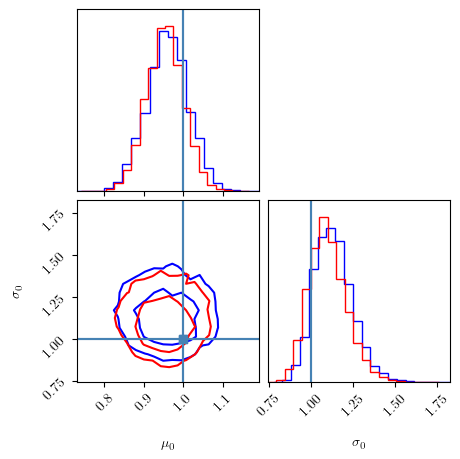

In [11]:
fig = plt.figure(figsize = (5, 5))
fig = cornerplot(result_NDE, fig, "blue")
fig = cornerplot(result_analytic, fig, "red")